In [1]:
import pandas as pd
df = pd.read_csv('西屯日報表train.csv',engine = 'python')

In [2]:
df.columns

Index(['month', 'day', 'hour', 'RH', 'StnPres', 'Temperature', 'AMB_TEMP',
       'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PH_RAIN', 'RAINFALL',
       'RAIN_COND', 'PM10', 'RH.1', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR', 'PM2.5'],
      dtype='object')

In [3]:
from matplotlib import pyplot
values = df.values
# specify columns to plot
groups = [3,4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

<Figure size 640x480 with 5 Axes>

In [4]:
from sklearn import preprocessing 
import pandas as pd
import numpy as np
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s_tsub%d' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s_t' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s_tadd%d' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg

In [5]:
'''
c = ['RH', 'StnPres', 'Temperature', 'AMB_TEMP','CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx',
     'O3', 'PH_RAIN', 'RAINFALL','RAIN_COND', 'PM10', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC','WIND_SPEED',
     'WS_HR','PM2.5']
'''
c = ['RH', 'StnPres', 'Temperature', 'CO', 'NO', 'NO2', 'NOx',
     'O3', 'PM10', 'SO2', 'WD_HR',
     'WS_HR','PM2.5', 'RAINFALL']#'WIND_DIREC'

In [6]:
dataset = df[c]

In [7]:
values = dataset.values
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
scaled = scaler.fit_transform(values[:,[0,1,2,3,4,5,6,7,8,9,10,11,12]])
scaled

array([[0.74117647, 0.82657343, 0.20858896, ..., 0.09722222, 0.06153846,
        0.17112299],
       [0.74117647, 0.82377622, 0.21472393, ..., 0.95833333, 0.03076923,
        0.21925134],
       [0.71764706, 0.81958042, 0.23619632, ..., 0.09444444, 0.03076923,
        0.22994652],
       ...,
       [0.78823529, 0.88531469, 0.38957055, ..., 0.04166667, 0.22307692,
        0.07486631],
       [0.77647059, 0.88391608, 0.38957055, ..., 0.03333333, 0.18461538,
        0.04812834],
       [0.77647059, 0.88671329, 0.38650307, ..., 0.03888889, 0.16923077,
        0.02673797]])

In [8]:
dataset.columns

Index(['RH', 'StnPres', 'Temperature', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'SO2', 'WD_HR', 'WS_HR', 'PM2.5', 'RAINFALL'],
      dtype='object')

In [9]:
#scaled = np.array(values[:,0],scaled.data)
label_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
scaled_con = np.c_[scaled,label_scaler.fit_transform(values[:,13].reshape(-1, 1))]
scaled_con

array([[0.74117647, 0.82657343, 0.20858896, ..., 0.06153846, 0.17112299,
        0.        ],
       [0.74117647, 0.82377622, 0.21472393, ..., 0.03076923, 0.21925134,
        0.        ],
       [0.71764706, 0.81958042, 0.23619632, ..., 0.03076923, 0.22994652,
        0.        ],
       ...,
       [0.78823529, 0.88531469, 0.38957055, ..., 0.22307692, 0.07486631,
        0.        ],
       [0.77647059, 0.88391608, 0.38957055, ..., 0.18461538, 0.04812834,
        0.        ],
       [0.77647059, 0.88671329, 0.38650307, ..., 0.16923077, 0.02673797,
        0.        ]])

In [10]:

# frame as supervised learning
reframed = series_to_supervised(scaled_con,c, 12, 1)

In [11]:
def select(attr):
    c = []
    for i in range(4,13):
        c.append(attr + '_tsub' + str(i))
    return c

In [12]:
cf = []
for i in range(len(c)):
    cf.extend(select(c[i]))
#cf.append('PM2.5_t')
cf.append('RAINFALL_t')
reframed_df = reframed[cf]

In [13]:
from sklearn.model_selection import train_test_split  
values = reframed_df.values
X,y = values[:, :-1], values[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=12) #to ml

In [14]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(42057, 1, 198) (42057,) (10515, 1, 198) (10515,)


arima

In [15]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [16]:
from matplotlib import pyplot
%matplotlib qt5
pyplot.rcParams['figure.figsize'] = (50, 50)
pyplot.plot(label_scaler.inverse_transform(train_y.reshape(-1, 1)), label="Actual (%s)" % 'pollution1(t)')
pyplot.legend()

In [16]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
testStationarity(train_y)

Test Statistic                  -206.574855
p-value                            0.000000
#Lags Used                         0.000000
Number of Observations Used    42056.000000
Critical Value (5%)               -2.861609
Critical Value (1%)               -3.430505
Critical Value (10%)              -2.566807
dtype: float64

In [17]:
train_y1 = train_y[:35000]
test_y1 = train_y[35000:]

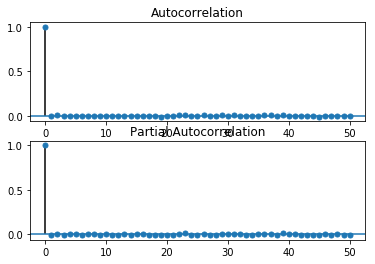

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def draw_acf_pacf(ts, lags=50):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=50, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=50, ax=ax2, alpha=0.05)
    plt.show()
%matplotlib inline
draw_acf_pacf(train_y)

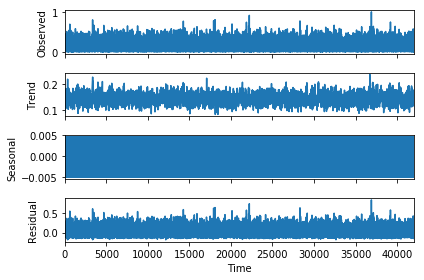

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_y, model="additive",freq = 24)#multiplicativeadditive

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig = decomposition.plot()
plt.show()

In [20]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]#12

In [22]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            aic.append(results.aic)
        except:
            continue
print(min(aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:-29564.600127892587
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:-44389.61604306794
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:-51969.985200719435
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:-81109.70262992769
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:-58643.103876903806
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:-81123.25570583665
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:-63997.49075675295
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:-81108.65575053882
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:-44185.08109352889
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:-51363.45341762254
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:-51967.38651574358
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:-81107.63339111512
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:-59291.35277981748
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:-81119.86406475169
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:-63999.393780919396
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:-81108.84552394737
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:-51789.13484349806
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:-51775.957895810694
ARIMA(0, 1, 0)x(0, 1, 0

In [21]:
mod = sm.tsa.statespace.SARIMAX(train_y1,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0088      0.005     -1.627      0.104      -0.019       0.002
ma.L1         -1.0000      0.010    -96.309      0.000      -1.020      -0.980
sigma2         0.0084   9.04e-05     93.324      0.000       0.008       0.009


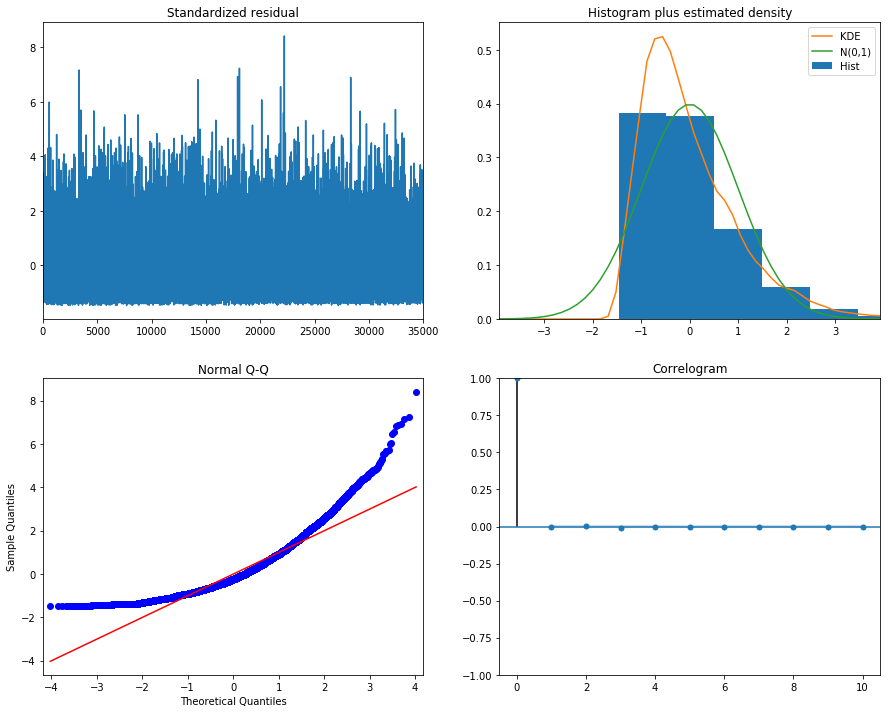

In [22]:
%matplotlib inline
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [23]:
yhat = []
pa = results.params
for i in range(int(len(test_y1)/7)):
    last_obs = mod.data.endog[-7]
    observations = [last_obs, test_y1[7*i], test_y1[7*i+1], test_y1[7*i+2], test_y1[7*i+3], test_y1[7*i+4], test_y1[7*i+5], test_y[7*i+6]]
    mod = sm.tsa.SARIMAX(observations, order=(1, 1, 1),seasonal_order=(0, 0, 0, 4),)#np.hstack((train_y,test_y))
    res = mod.filter(pa)#mod2.smooth(results.params)
    yhat.extend(res.forecast(steps=7))
    pa = res.params
yhat

[0.1040654020089827,
 0.10479441619950221,
 0.10478802078070582,
 0.10478807688576126,
 0.10478807639356875,
 0.1047880763978866,
 0.10478807639784873,
 0.17789686416246445,
 0.1776967006597056,
 0.17769845663297,
 0.17769844122835296,
 0.17769844136349297,
 0.17769844136230742,
 0.17769844136231783,
 0.09781940815170748,
 0.09761804763467254,
 0.09761981410897748,
 0.09761979861223802,
 0.09761979874818617,
 0.09761979874699354,
 0.09761979874700401,
 0.1260979649421669,
 0.12635221735889757,
 0.12634998688011384,
 0.12635000644742286,
 0.12635000627576484,
 0.12635000627727075,
 0.12635000627725754,
 0.1894509421097366,
 0.19076321870045115,
 0.19075170649879108,
 0.19075180749181952,
 0.19075180660583854,
 0.190751806613611,
 0.1907518066135428,
 0.10357893809687677,
 0.10365544061758891,
 0.10365476948434446,
 0.1036547753719914,
 0.10365477532034087,
 0.10365477532079398,
 0.10365477532079001,
 0.2080766404086388,
 0.2092067543159243,
 0.20919684017183945,
 0.20919692714559696,
 0

In [73]:
yhat = []
pa = results.params
for i in range(len(test_y1)):
    last_obs = mod.data.endog[-1]
    observations = [last_obs, test_y1[i]]
    mod = sm.tsa.SARIMAX(observations, order=(1, 1, 1),seasonal_order=(0, 0, 0, 4),)#np.hstack((train_y,test_y))
    res = mod.filter(pa)#mod2.smooth(results.params)
    yhat.append(res.forecast(steps=1)[0])
    pa = res.params
yhat

[0.1463319626461436,
 0.122702673165376,
 0.08821183734846856,
 0.1068111328402645,
 0.09119056724708072,
 0.08267659263846094,
 0.19176276356530972,
 0.18796329199163747,
 0.22082268224003007,
 0.2548316678870406,
 0.14982644525867514,
 0.160240155654131,
 0.18181818104453912,
 0.2666290734071788,
 0.22042415565218673,
 0.14651932584778335,
 0.12639559686889945,
 0.09048687543505285,
 0.09663198638215123,
 0.06672763753299749,
 0.13057037074231984,
 0.12351069254522434,
 0.15428269585690668,
 0.19563283642582385,
 0.16293740882793203,
 0.1367623944768868,
 0.06705602704527716,
 0.08518619466238783,
 0.0912374800345492,
 0.183342614531627,
 0.3128576796615442,
 0.2253495341251035,
 0.1840932191311234,
 0.15308665188209847,
 0.11462141563685642,
 0.1312271497668792,
 0.14405663661132492,
 0.09965762906823195,
 0.018693121066733,
 0.10620126660317368,
 0.1686603046878137,
 0.07812651646529234,
 0.2094707160952037,
 0.3402055136993025,
 0.17726810487137057,
 0.1253166027571234,
 0.1154189

In [24]:
yhat = np.array(yhat)

In [27]:
from matplotlib import pyplot
%matplotlib qt5
pyplot.rcParams['figure.figsize'] = (50, 50)
pyplot.plot(label_scaler.inverse_transform(test_y1.reshape(-1, 1)), label="Actual (%s)" % 'pollution1(t)')
pyplot.plot(label_scaler.inverse_transform(yhat.reshape(-1, 1)), label="Predicted (%s)" % 'pollution1(t)')
pyplot.legend()
#pyplot.show()
#pyplot.savefig('test.png')

XGBoost


In [14]:
import xgboost as xgb
#only sklearn
import sklearn
reframed = sklearn.utils.shuffle(reframed_df)
values = reframed.values
X,y = values[:, :-1], values[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=12) #to ml

In [15]:
dtrain = xgb.DMatrix(data=train_X,label=train_y)
dtest = xgb.DMatrix(data=test_X,label=test_y)

In [16]:
param = {'max_depth': 7, 'eta': 1, 'silent': 1, 'objective': 'reg:linear'}
param['nthread'] = 4
param['seed'] = 100
param['eval_metric'] = ['rmse']
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [17]:
num_round = 10
bst_with_evallist = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:0.013091	train-rmse:0.009425
[1]	eval-rmse:0.013093	train-rmse:0.008494
[2]	eval-rmse:0.013348	train-rmse:0.00778
[3]	eval-rmse:0.013556	train-rmse:0.007421
[4]	eval-rmse:0.013588	train-rmse:0.006959
[5]	eval-rmse:0.013699	train-rmse:0.006732
[6]	eval-rmse:0.013837	train-rmse:0.006474
[7]	eval-rmse:0.013874	train-rmse:0.006138
[8]	eval-rmse:0.013869	train-rmse:0.005975
[9]	eval-rmse:0.013914	train-rmse:0.005683


In [19]:
yhat = xgb.DMatrix(test_X)

In [25]:
yhat =  bst_with_evallist.predict(yhat)

ml

In [14]:
#only sklearn
import sklearn
reframed = sklearn.utils.shuffle(reframed_df)
values = reframed.values

In [15]:
X,y = values[:, :-1], values[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=12) #to ml

In [26]:
from sklearn import preprocessing,svm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import *
regressor = LinearRegression(n_jobs = -1)
#BaggingRegressor(random_state=0, n_estimators=10)
#RandomForestRegressor(n_estimators = 10,random_state=0,max_depth = 5)
#DecisionTreeRegressor(max_depth=5,random_state=1)
#LinearRegression(n_jobs = -1)
regressor.fit(train_X, train_y)
regressor.score(test_X,test_y)

0.02805118537247142

In [27]:
from sklearn.linear_model import Ridge,Lasso
alphas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
scores = []
for i, alpha in enumerate(alphas):
    regressor = Ridge(alpha=alpha)#Ridge
    regressor.fit(train_X, train_y)
    scores.append(regressor.score(test_X, test_y))
for i in range(len(alphas)):
    print(alphas[i], scores[i])

0.01 0.02823684083268474
0.02 0.02840743431295978
0.05 0.02887054619179963
0.1 0.029552958368788018
0.2 0.030729297193848204
0.5 0.033435505930832665
1 0.03642141427772283
2 0.039550197610510374
5 0.041522328088707705
10 0.04015101775014518
20 0.036966313809739915
50 0.032449320189909425
100 0.0297836735669329
200 0.02752323011450042
500 0.024122532342074954
1000 0.020778944700765245


In [20]:
yhat = regressor.predict(test_X)
#print("W:%s, b:%.2f" % (regressor.coef_, regressor.intercept_))
#print("LOSS:%.2f" % np.mean((regressor.predict(test_X) - test_y) ** 2))

In [27]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(regressor, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.68 (+/- 0.02)


cnnlstm

In [28]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [16]:
#model.add(Dropout(0.2))
def baseline_model():
    # design network
    model = Sequential()
    #CNN
    model.add(Conv1D(filters=64, kernel_size=1, input_shape=(train_X.shape[1], train_X.shape[2])))#kernel1 shape
    model.add(Activation('selu'))
    model.add(Dropout(0.2))
#    model.add(Conv1D(filters=64, kernel_size=1))
#    model.add(BatchNormalization())
#    model.add(Activation('selu'))
#    model.add(Dropout(0.2))
    #lstm
    model.add(LSTM(units=128))
    model.add(Dropout(0.2))
    model.add(Dense(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))#10
    model.add(Activation('sigmoid'))
    adam = Adam(0.01)
    model.compile(loss='mse', optimizer=adam,metrics=['accuracy'])##categorical_crossentropy##
    return model

In [ ]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [17]:
model = baseline_model()
history = model.fit(train_X, train_y, epochs=50, batch_size=500, validation_data=(test_X, test_y), verbose=1, shuffle=True)#callbacks=[tbCallBack]

Train on 42057 samples, validate on 10515 samples
Epoch 1/50
42057/42057 [==============================] - 29s 686us/step - loss: 0.0244 - acc: 0.0014 - val_loss: 0.0222 - val_acc: 0.0023
Epoch 2/50
42057/42057 [==============================] - 1s 23us/step - loss: 0.0227 - acc: 0.0014 - val_loss: 0.0222 - val_acc: 0.0023
Epoch 3/50
42057/42057 [==============================] - 1s 24us/step - loss: 0.0227 - acc: 0.0014 - val_loss: 0.0222 - val_acc: 0.0023
Epoch 4/50
42057/42057 [==============================] - 1s 23us/step - loss: 0.0227 - acc: 0.0014 - val_loss: 0.0222 - val_acc: 0.0023
Epoch 5/50
42057/42057 [==============================] - 1s 24us/step - loss: 0.0227 - acc: 0.0014 - val_loss: 0.0222 - val_acc: 0.0023
Epoch 6/50
42057/42057 [==============================] - 1s 23us/step - loss: 0.0227 - acc: 0.0014 - val_loss: 0.0222 - val_acc: 0.0023
Epoch 7/50
42057/42057 [==============================] - 1s 24us/step - loss: 0.0227 - acc: 0.0014 - val_loss: 0.0222 - val_a

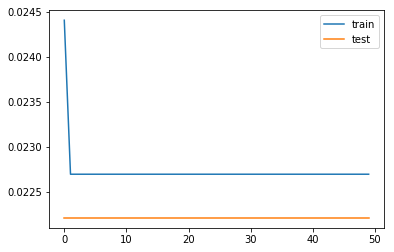

In [18]:
from matplotlib import pyplot
%matplotlib inline
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 64)             12736     
_________________________________________________________________
activation_1 (Activation)    (None, 1, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
__________

In [20]:
# make a prediction
yhat = model.predict(test_X)
yhat

array([[1.8865584e-11],
       [1.1787917e-11],
       [1.4618291e-11],
       ...,
       [1.4195827e-11],
       [1.6751482e-11],
       [1.3446184e-11]], dtype=float32)

In [21]:
def to_class(pre_pm):
    if pre_pm <= 11:
        return 0
    elif 11 < pre_pm <= 23:
        return  1
    elif 23 < pre_pm <= 35:
        return  2
    elif 35 < pre_pm <= 41:
        return  3
    elif 41 < pre_pm <= 47:
        return  4
    elif 47 < pre_pm <= 53:
        return  5
    elif 53 < pre_pm <= 58:
        return  6
    elif 58 < pre_pm <= 64:
        return  7
    elif 64 < pre_pm <= 70:
        return  8
    elif 70 < pre_pm:
        return  9

In [22]:
count = 0
for i in range(len(yhat)):
    after_pm = label_scaler.inverse_transform(yhat[i].reshape(-1, 1))[0][0]
    pre_pm = label_scaler.inverse_transform(test_y[i].reshape(-1, 1))[0][0]
    if to_class(after_pm) == to_class(pre_pm) :#or abs(to_class(after_pm) - to_class(pre_pm)) == 1:
        count = count + 1
print(count/len(yhat))

0.3040418449833571


In [23]:
count = 0
ally = 0
for i in range(len(yhat)):
    after_pm = label_scaler.inverse_transform(yhat[i].reshape(-1, 1))[0][0]
    pre_pm = label_scaler.inverse_transform(test_y[i].reshape(-1, 1))[0][0]
    if to_class(pre_pm) >= 6:
        ally = ally + 1
        if to_class(after_pm) >= 6 :#or abs(to_class(after_pm) - to_class(pre_pm)) == 1:
            count = count + 1
print(count/ally)

0.0


In [27]:
inv_yhat = label_scaler.inverse_transform(yhat.reshape(-1, 1) )
inv_y = label_scaler.inverse_transform(test_y.reshape(-1, 1))

In [28]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)
# calculate average error percentage
avg = np.average(inv_y)
error_percentage = rmse / avg
print(error_percentage)

9.044258846252678
10.048401377433443


In [30]:
from matplotlib import pyplot
%matplotlib qt5
pyplot.rcParams['figure.figsize'] = (50, 50)
pyplot.plot(inv_y, label="Actual (%s)" % 'pollution1(t)')
pyplot.plot(inv_yhat, label="Predicted (%s)" % 'pollution1(t)')
pyplot.legend()

In [29]:
from sklearn.metrics import explained_variance_score, mean_absolute_error,median_absolute_error,r2_score,mean_squared_error
print("The Explained Variance: %.2f" % explained_variance_score(inv_y, inv_yhat))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(inv_y,inv_yhat))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(inv_y, inv_yhat))
print("The r2_score: %.2f" % r2_score(inv_y, inv_yhat)) 
print("The mse: %.2f" % mean_squared_error(inv_y, inv_yhat))

The Explained Variance: -0.13
The Mean Absolute Error: 1.63 degrees Celcius
The Median Absolute Error: 0.32 degrees Celcius
The r2_score: -0.13
The mse: 81.80


In [ ]:
model.save('CNNLSTM.h5') 
# 從 HDF5 檔案中載入模型
#model = tf.contrib.keras.models.load_model('CNNLSTM.h5')
#tensorboard --logdir ./logs 